# Testing New Implementation of $c_1$ with Single Nanoflare
New implementation in the two-fluid model is showing unexpected differences when tested against nanoflare trains. Simplify comparison and test again.

In [138]:
import sys,os
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('papers')
import seaborn.apionly as sns
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_analysis/src'))
import ebtel_configure as ebc
import ebtel_run as ebr
import em_binner as emb
%matplotlib inline

Configure base dictionary.

In [139]:
config_dict = {'usage_option':'no_dem','rad_option':'rk','dem_option':'new','heat_flux_option':'limited',
              'solver':'rka4','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['total_time'] = 5e3
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['amp_switch'] = 'uniform'
config_dict['num_events'] = 1
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 2.5
config_dict['loop_length'] = 40.0
config_dict['t_pulse_half'] = 100
config_dict['h_nano'] = 10/config_dict['t_pulse_half']
config_dict['sample_rate'] = 1
config_dict['output_file'] = 'ebtel_data/c1_single_nanoflare_tests'
config_dict['heat_species'] = 'electron'
#variable c1 options
config_dict['r3_grav_correction'] = 'True'
config_dict['r3_loss_correction'] = 'True'
config_dict['r3_rad_0'] = 0.6

Configure runner and printer objects

In [140]:
configurer = ebc.Configurer(config_dict,'')
runner = ebr.Runner(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL-2fluid_repo/bin/'),'')

Do the run for an unaltered $c_1$ during the conductive phase.

In [141]:
configurer.config_dictionary['r3_cond_0'] = 2.0

In [142]:
configurer.print_xml_config(config_file=config_dict['output_file']+'.xml')
runner.run_ebtel_single(config_dict['output_file']+'.xml',verbose=False)

Load the data.

In [143]:
data_cond_2 = np.loadtxt(config_dict['output_file']+'.txt')

Run the model with the modified $c_1$ during the conductive phase.

In [144]:
configurer.config_dictionary['r3_cond_0'] = 6.0

In [145]:
configurer.print_xml_config(config_file=config_dict['output_file']+'.xml')
runner.run_ebtel_single(config_dict['output_file']+'.xml',verbose=False)

In [146]:
data_cond_6 = np.loadtxt(config_dict['output_file']+'.txt')

Now do a `git checkout master` to switch back to the old version and run the model with the old prescription of $c_1$. (**NOTE:** This stype will really only work when the codebase is in the current state.)

In [135]:
runner.run_ebtel_single(config_dict['output_file']+'.xml',verbose=False)
data_old = np.loadtxt(config_dict['output_file']+'.txt')

Now compare all of the results using the emission measure distribution.

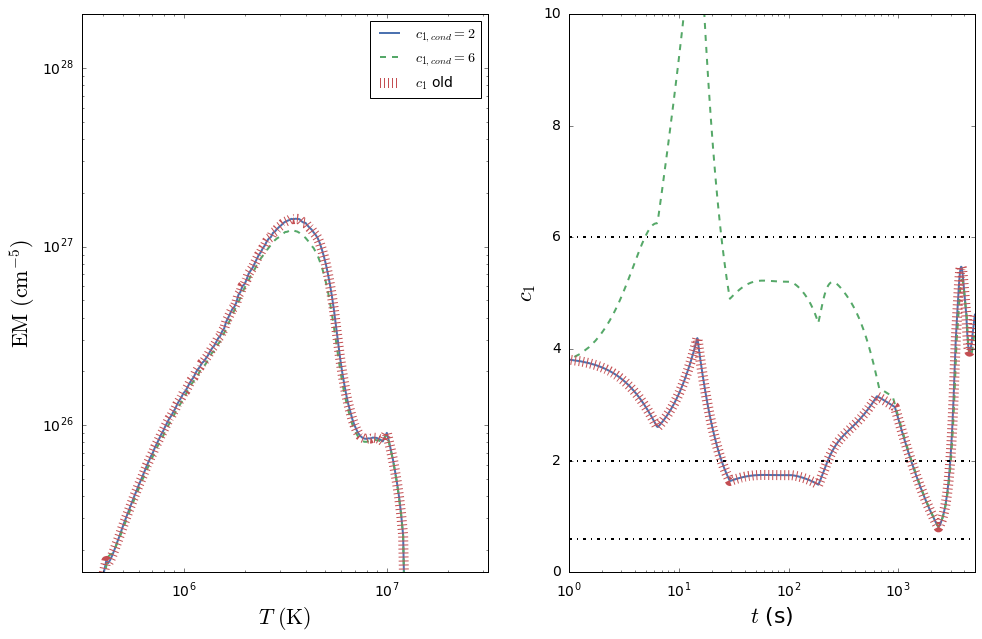

In [148]:
fig,ax = plt.subplots(1,2,figsize=(16,10))
#set density index
n_index = 3
#c1_cond=2
binner = emb.EM_Binner(2.*config_dict['loop_length']*1e+8,time=data_cond_2[:,0],
                               temp=data_cond_2[:,1], density=data_cond_2[:,n_index])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[0],
               linestyle='solid',label=r'$c_{1,cond}=2$')
ax[1].plot(data_cond_2[:,0],data_cond_2[:,-3],color=sns.color_palette('deep')[0],
               linestyle='solid')
#c1_cond=6
binner = emb.EM_Binner(2.*config_dict['loop_length']*1e+8,time=data_cond_6[:,0],
                               temp=data_cond_6[:,1], density=data_cond_6[:,n_index])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[1],
               linestyle='dashed',label=r'$c_{1,cond}=6$')
ax[1].plot(data_cond_6[:,0],data_cond_6[:,-3],color=sns.color_palette('deep')[1],
               linestyle='dashed')
#old c1
binner = emb.EM_Binner(2.*config_dict['loop_length']*1e+8,time=data_old[:,0],
                               temp=data_old[:,1], density=data_old[:,n_index])
binner.build_em_dist()
hist,bin_edges = np.histogram(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=np.array(binner.em_flat))
ax[0].plot((bin_edges[:-1]+bin_edges[1:])/2,hist/10,color=sns.color_palette('deep')[2],
               linestyle='dotted',label=r'$c_1$ old',linewidth=10)
ax[1].plot(data_old[:,0],data_old[:,-3],color=sns.color_palette('deep')[2],
               linestyle='dotted',linewidth=10)
#reference lines
ax[1].axhline(y=0.6,color='k',linestyle='-.')
ax[1].axhline(y=2.0,color='k',linestyle='-.')
ax[1].axhline(y=6.0,color='k',linestyle='-.')
#styles,labels etc
ax[0].legend(loc='best')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim([1.5e+25,2e+28])
ax[0].set_xlim([10**5.5,10**7.5])
ax[0].set_xlabel(r'$T\,\,\mathrm{(K)}$')
ax[0].set_ylabel(r'$\mathrm{EM}\,\,(\mathrm{cm}^{-5})$')
ax[1].set_xlabel(r'$t$ (s)')
ax[1].set_ylabel(r'$c_1$')
ax[1].set_xscale('log')
ax[1].set_xlim([0,config_dict['total_time']])
ax[1].set_ylim([0,10])
#show
plt.show()

The problem turns out to be differing values of $c_2$. Old value was $c_2=0.84$. Value derived by Cargill et. al (2012a) is $c_2=0.9$. We will use $c_2=0.9$ in both the single- and two-fluid versions for consistency.